
Testa a eficiencia de uma arquitetura Baseada na VGG em diferenciar frames de Tomografia Computadorizada (CT) contendo infecção por COVID de frames de Pulmões saldáveis
---



In [1]:
# Monta o drive para ler os dados salvos no mesmo
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip3 install pickle5
import pickle5 as pickle

In [3]:
# Importa as bibliotecas necessárias
import os
#import pickle
import cv2
import nibabel as nib
import numpy as np

import tensorflow as tf
from tensorflow.keras import Model,layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications
from tensorflow.keras.models import load_model



import matplotlib.pyplot as plt


In [4]:
# Normaliza as imagens
def normImage(image):
    image-=np.min(image)
    image = (image/np.max(image))*255
    return image.astype('uint8')

In [5]:
# Função para gerar o modelo
def get_model(IMG_HEIGHT, IMG_WIDTH, CHANNELS,ini_filter = 64):
    in1 = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS ))
        
    
    #layers convolucionais baseados na U-net
    conv1 = layers.Conv2D(int(ini_filter), (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = layers.Dropout(0.2)(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1) 

    conv2 = layers.Conv2D(int(ini_filter*2), (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = layers.Dropout(0.2)(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2) 

    conv3 = layers.Conv2D(int(ini_filter*4), (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = layers.Dropout(0.2)(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3) 

    conv4 = layers.Conv2D(int(ini_filter*4), (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = layers.Dropout(0.2)(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4) 
    
    flat1 = layers.Flatten()(pool4)
 
    output = layers.Dense(2, activation='softmax',name='out')(flat1)
    
    model = Model(inputs=[in1], outputs=[output])

    losses = {'out': 'binary_crossentropy'}

    metrics = {'out': ['acc']}

    model.compile(optimizer="adam", loss = losses, metrics=metrics)

    return model

In [6]:
#carregar os dados
with open(os.path.join('/content/gdrive/MyDrive/dados',
                       'covid_set_256x256_raw.pickle'), 'rb') as handle:
    covid_set = pickle.load(handle)


In [7]:
# Remodelar os dados para o treino
X_train = np.array(covid_set['X_train']).reshape((-1,256,256,1))
y_train = np.array(covid_set['y_train']).reshape((-1,1))
X_test = np.array(covid_set['X_test']).reshape((-1,256,256,1))
y_test = np.array(covid_set['y_test']).reshape((-1,1))
y_train = np.hstack((y_train,1-y_train))
y_test = np.hstack((y_test,1-y_test))


In [8]:
#carregar o modelo de segmentação
unet = load_model(os.path.join('/content/gdrive/MyDrive/dados','DNN_lungs_segmentation.hdf5'))

train_masks = unet.predict(X_train)
test_masks = unet.predict(X_test)

train_masks = np.round(train_masks)
test_masks = np.round(test_masks)

In [9]:
X_train = X_train*train_masks
X_test = X_test*test_masks

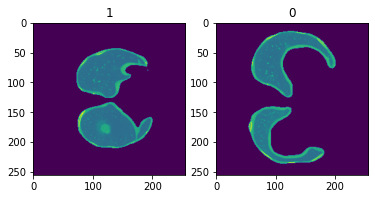

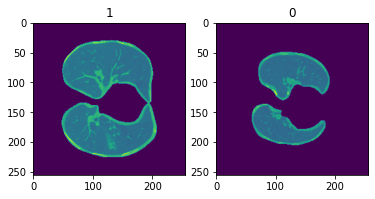

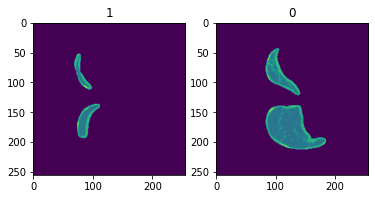

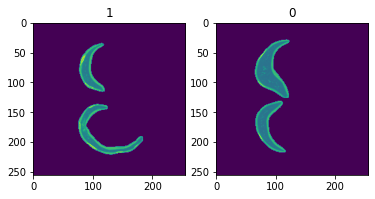

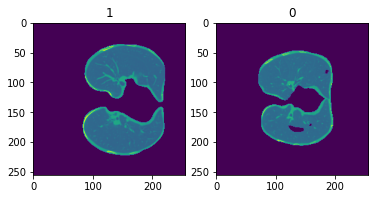

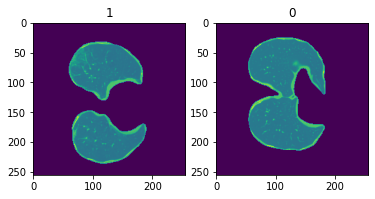

In [10]:
# Mostrar parte do dataset
# 1 -> Covid || 0-> Saudável
for i in range(1,502,100):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(X_train[i-1,:,:,0])
    ax1.set_title(str(y_train[i-1,0]))
    
    ax2.imshow(X_train[i,:,:,0])
    ax2.set_title(str(y_train[i,0]))

In [11]:
# Liberar um pouco de memória
del covid_set

In [12]:
# criar modelo
model = get_model(IMG_HEIGHT=256, 
                  IMG_WIDTH=256, 
                  CHANNELS=1)

# Treinar o modelo
EPOCHS=20
BATCH_SIZE=32
history = model.fit(X_train, y_train , epochs=EPOCHS, 
                    batch_size = BATCH_SIZE,shuffle=True, 
                    validation_data=(X_test, y_test))

Epoch 1/20
40/40 [==============================] - 15s 259ms/step - loss: 1.1690 - acc: 0.5775 - val_loss: 0.6938 - val_acc: 0.4843
Epoch 2/20
40/40 [==============================] - 8s 199ms/step - loss: 0.5489 - acc: 0.7188 - val_loss: 0.8295 - val_acc: 0.4874
Epoch 3/20
40/40 [==============================] - 8s 201ms/step - loss: 0.4468 - acc: 0.7891 - val_loss: 0.8253 - val_acc: 0.5126
Epoch 4/20
40/40 [==============================] - 8s 201ms/step - loss: 0.3653 - acc: 0.8403 - val_loss: 1.0369 - val_acc: 0.5377
Epoch 5/20
40/40 [==============================] - 8s 202ms/step - loss: 0.3005 - acc: 0.8682 - val_loss: 1.0571 - val_acc: 0.4371
Epoch 6/20
40/40 [==============================] - 8s 203ms/step - loss: 0.3159 - acc: 0.8634 - val_loss: 1.0042 - val_acc: 0.5094
Epoch 7/20
40/40 [==============================] - 8s 202ms/step - loss: 0.2243 - acc: 0.9145 - val_loss: 1.0177 - val_acc: 0.5157
Epoch 8/20
40/40 [==============================] - 8s 201ms/step - loss: 0

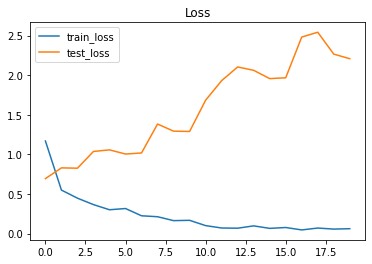

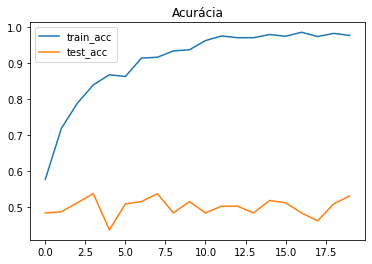

In [13]:
#plotar o resultado do treino
plt.figure()
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='test_loss')
plt.title('Loss')
plt.legend()


plt.figure()
plt.plot(history.history['acc'],label='train_acc')
plt.plot(history.history['val_acc'],label='test_acc')
plt.title('Acurácia')
plt.legend()


In [14]:
# Testar com menos filtros
# criar modelo
model = get_model(IMG_HEIGHT=256, 
                  IMG_WIDTH=256, 
                  CHANNELS=1,
                  ini_filter = 8)

# Treinar o modelo
EPOCHS=20
BATCH_SIZE=32
history = model.fit(X_train, y_train , epochs=EPOCHS, 
                    batch_size = BATCH_SIZE,shuffle=True, 
                    validation_data=(X_test, y_test))

Epoch 1/20
40/40 [==============================] - 3s 44ms/step - loss: 0.6705 - acc: 0.6142 - val_loss: 0.6970 - val_acc: 0.5157
Epoch 2/20
40/40 [==============================] - 1s 30ms/step - loss: 0.5638 - acc: 0.7093 - val_loss: 0.7316 - val_acc: 0.5283
Epoch 3/20
40/40 [==============================] - 1s 31ms/step - loss: 0.4956 - acc: 0.7524 - val_loss: 0.7375 - val_acc: 0.5597
Epoch 4/20
40/40 [==============================] - 1s 30ms/step - loss: 0.4074 - acc: 0.8251 - val_loss: 0.8863 - val_acc: 0.5409
Epoch 5/20
40/40 [==============================] - 1s 31ms/step - loss: 0.3922 - acc: 0.8227 - val_loss: 0.8191 - val_acc: 0.5566
Epoch 6/20
40/40 [==============================] - 1s 31ms/step - loss: 0.3354 - acc: 0.8546 - val_loss: 0.8601 - val_acc: 0.5346
Epoch 7/20
40/40 [==============================] - 1s 31ms/step - loss: 0.2711 - acc: 0.8938 - val_loss: 0.9455 - val_acc: 0.5252
Epoch 8/20
40/40 [==============================] - 1s 30ms/step - loss: 0.2293 - a

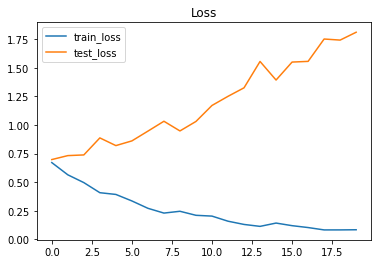

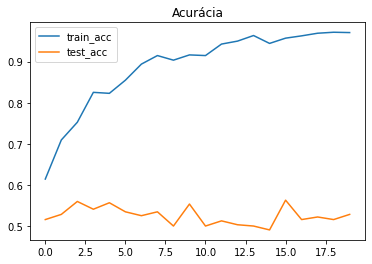

In [15]:
#plotar o resultado do treino
plt.figure()
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='test_loss')
plt.title('Loss')
plt.legend()


plt.figure()
plt.plot(history.history['acc'],label='train_acc')
plt.plot(history.history['val_acc'],label='test_acc')
plt.title('Acurácia')
plt.legend()